#### Import packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kaggle_environments import make

from lux.game import Game
from lux.game_map import Cell, RESOURCE_TYPES, Position
from lux.constants import Constants
from lux.game_constants import GAME_CONSTANTS
from lux import annotate
import math
import sys
import random

Loading environment football failed: No module named 'gfootball'


#### Functions to find resource related metrics

In [2]:
# this snippet finds all resources stored on the map and puts them into a list so we can search over them
def find_resources(game_state):
    resource_tiles: list[Cell] = []
    width, height = game_state.map_width, game_state.map_height
    for y in range(height):
        for x in range(width):
            cell = game_state.map.get_cell(x, y)
            if cell.has_resource():
                resource_tiles.append(cell)
    return resource_tiles

def find_resource_patches(game_state, player):
    width, height = game_state.map_width, game_state.map_height
    patches, patch_values = [], []
    for y in range(height):
        for x in range(width):
            if y % 4 == 0:
                if x % 4 == 0:
                    patches.append((x,y))

    for patch in patches:
        patch_resource_count = 0
        patch_city_tile_count = 0
        patch_enemy_city_tile_count = 0
        for x1 in range(patch[0], patch[0]+4):
            for y1 in range(patch[1], patch[1]+4):
                cell = game_state.map.get_cell(x1, y1)

                if cell.citytile is not None:
                    if cell.citytile.team == player:
                        patch_city_tile_count +=1
                    else:
                        patch_enemy_city_tile_count +=1
                    
                if cell.has_resource():
                    if cell.resource.type == Constants.RESOURCE_TYPES.URANIUM:
                        if player.researched_uranium(): 
                            patch_resource_count += 4
                  
                    elif cell.resource.type == Constants.RESOURCE_TYPES.COAL:
                        if player.researched_coal(): 
                            patch_resource_count += 2
                    else:
                        patch_resource_count += 1
        patch_values.append([patch, patch_resource_count, patch_city_tile_count, patch_enemy_city_tile_count])
            
    return(patch_values)

# the next snippet finds the closest resources that we can mine given position on a map
def find_closest_resources(pos, player, resource_tiles):
    closest_dist = math.inf
    closest_resource_tile = None
    for resource_tile in resource_tiles:
        # we skip over resources that we can't mine due to not having researched them
        if resource_tile.resource.type == Constants.RESOURCE_TYPES.COAL and not player.researched_coal(): continue
        if resource_tile.resource.type == Constants.RESOURCE_TYPES.URANIUM and not player.researched_uranium(): continue
        dist = resource_tile.pos.distance_to(pos)
        if dist < closest_dist:
            closest_dist = dist
            closest_resource_tile = resource_tile
    return closest_resource_tile

def find_resources_perimeter_tiles(game_state):
    perimeter_tiles: list[Cell] = []
    width, height = game_state.map_width, game_state.map_height
    resource_tiles = find_resources(game_state)
    for y in range(height):
        for x in range(width):
            cell = game_state.map.get_cell(x, y)
            for resource_tile in resource_tiles:
                if not cell.has_resource() and cell.pos.is_adjacent(resource_tile.pos) and not cell.citytile:
                    perimeter_tiles.append(cell)
    return perimeter_tiles
    
def find_closest_perimeter_tile(pos, player, perimeter_tiles):
    closest_dist = math.inf
    closest_perimeter_tile = None
    for perimeter_tile in perimeter_tiles:
        dist = perimeter_tile.pos.distance_to(pos)
        if dist < closest_dist:
            closest_dist = dist
            closest_perimeter_tile = perimeter_tile
    return closest_perimeter_tile

#### Functions to find city related metrics

In [3]:
def find_closest_city_tile(pos, player):
    closest_city_tile = None
    if len(player.cities) > 0:
        closest_dist = math.inf
        # the cities are stored as a dictionary mapping city id to the city object, which has a citytiles field that
        # contains the information of all citytiles in that city
        for k, city in player.cities.items():
            for city_tile in city.citytiles:
                dist = city_tile.pos.distance_to(pos)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_city_tile = city_tile
    return closest_city_tile

def find_city_adjacent_empty_tiles(player):
    width, height = game_state.map_width, game_state.map_height
    adjacent_empty_tiles = []
    city_tiles_positions = []
    if len(player.cities) > 0:
        for k, city in player.cities.items():
            for city_tile in city.citytiles:
                city_tiles_positions.append(city_tile.pos)
                if city_tile.pos.x>=1 and  city_tile.pos.x < width and city_tile.pos.y >=1 and city_tile.pos.y < height:
                    for y in range(city_tile.pos.y-1, city_tile.pos.y+1):
                        for x in range(city_tile.pos.x-1, city_tile.pos.x+1):
                            cell = game_state.map.get_cell(x, y)
                            if cell.pos.is_adjacent(city_tile.pos):
                                for ctp in city_tiles_positions:
                                    if cell.pos.equals(ctp):
                                        continue
                                    else:
                                        if not cell.has_resource():
                                            adjacent_empty_tiles.append(cell)
    return adjacent_empty_tiles
        
def find_closest_uranium(pos, player, resource_tiles):
    closest_dist = math.inf
    closest_uranium_tile = None
    for resource_tile in resource_tiles:
        if not (resource_tile.resource.type == Constants.RESOURCE_TYPES.URANIUM): continue    
        dist = resource_tile.pos.distance_to(pos)
        if dist < closest_dist:
            closest_dist = dist
            closest_uranium_tile = resource_tile
    return closest_uranium_tile


def find_closest_coal(pos, player, resource_tiles):
    closest_dist = math.inf
    closest_coal_tile = None
    for resource_tile in resource_tiles:
        if not (resource_tile.resource.type == Constants.RESOURCE_TYPES.COAL): continue    
        dist = resource_tile.pos.distance_to(pos)
        if dist < closest_dist:
            closest_dist = dist
            closest_coal_tile = resource_tile
    return closest_coal_tile


def find_closest_city_tile_needing_fuel(pos, player):
    cities_needing_fuel = []
    #city_stats = []
    for k, city in player.cities.items():
        #city_stats.append([city, city.fuel])
        if city.fuel < city.get_light_upkeep()*5:
            cities_needing_fuel.append(city)
            
    closest_city_tile = None
    if len(player.cities) > 0:
        closest_dist = math.inf
        # the cities are stored as a dictionary mapping city id to the city object, which has a citytiles field that
        # contains the information of all citytiles in that city
        for city in cities_needing_fuel:
            for city_tile in city.citytiles:
                dist = city_tile.pos.distance_to(pos)
                if dist < closest_dist:
                    closest_dist = dist
                    closest_city_tile = city_tile
    return closest_city_tile

#### Functions to keep track of other units

In [4]:
def unit_will_collide(player, next_spot, positions_to_check):
    will_collide = False
    for location in positions_to_check:
        if next_spot.equals(location):
            will_collide = True
            break
    return will_collide

#### Functions to keep track of global metrics

In [5]:
def total_fuel_available(player):
    total_fuel_available = 0
    for k, city in player.cities.items():
        total_fuel_available += city.fuel
    return total_fuel_available

In [6]:
def time_to_night(game_state):
    if divmod(game_state.turn,40)[1]>=30:
        time_to_night = 0
    else:
        time_to_night= 30-divmod(game_state.turn,40)[1]
    return time_to_night

In [7]:
def move_to_a_city(player, unit, closest_city_tile, closest_city_tile_needing_fuel):
    action = None
    spot = None
    ### MOVE TO THE CLOSEST CITY TILE NEEDING FUEL IF IT EXISTS
    if closest_city_tile_needing_fuel is not None:
        spot = closest_city_tile_needing_fuel.pos
        action = unit.move(unit.pos.direction_to(spot))
        
    ### OTHERWISE MOVE TO THE CLOSEST CITY    
    else:
        if closest_city_tile is not None:
            spot = closest_city_tile.pos
            action = unit.move(unit.pos.direction_to(spot))
            
    return action, spot

def move_to_a_resource(player, unit, closest_resource_tile):
    action, spot = None, None
    if closest_resource_tile is not None:
        spot = closest_resource_tile.pos
        action = unit.move(unit.pos.direction_to(spot))
    return action, spot

def move_to_a_build_location(player, unit, closest_build_location):
    action, spot = None, None
    if closest_build_location is not None:
        spot = closest_build_location.pos
        action = unit.move(unit.pos.direction_to(spot))
    return action, spot
    
def move_randomly(player, unit, game_state):
    action = None
    directions = 'news'
    move_direction = random.choice(directions)
    if move_direction == 'n':
        if unit.pos.y-1 < 0 :
            new_loc = game_state.map.get_cell(unit.pos.x, unit.pos.y)
        else:
            new_loc = game_state.map.get_cell(unit.pos.x, unit.pos.y-1)
    elif move_direction == 's':
        if unit.pos.y + 1 >= game_state.map.height:
            new_loc = game_state.map.get_cell(unit.pos.x, unit.pos.y)
        else:
            new_loc = game_state.map.get_cell(unit.pos.x, unit.pos.y+1)
    elif move_direction == 'e':
        if unit.pos.x + 1 >= game_state.map.height:
            new_loc = game_state.map.get_cell(unit.pos.x, unit.pos.y)
        else:
            new_loc = game_state.map.get_cell(unit.pos.x+1, unit.pos.y)
    elif move_direction == 'w':
        if unit.pos.x-1 < 0 :
            new_loc = game_state.map.get_cell(unit.pos.x, unit.pos.y)
        else:
            new_loc = game_state.map.get_cell(unit.pos.x-1, unit.pos.y-1)
        
    spot = new_loc.pos
    action = unit.move(unit.pos.direction_to(spot))
           
    return action, spot

def ideal_build_locations(good_patches, player):
    build_locations = []
    for patch in good_patches:
        if 0 < patch[2] <= 5:
            for cell in find_city_adjacent_empty_tiles(player):
                build_locations.append(cell)
            break
        else:
            for x1 in range(patch[0][0], patch[0][0]+4):
                for y1 in range(patch[0][1], patch[0][1]+4):
                    cell = game_state.map.get_cell(x1, y1)
                    if cell.citytile is None and cell.has_resource() == False:
                        build_locations.append(cell)
    return(build_locations)

def find_closest_build_location(pos, player, build_locations):
    closest_build_location = None
    if len(build_locations) > 0:
        closest_dist = math.inf
        # the cities are stored as a dictionary mapping city id to the city object, which has a citytiles field that
        # contains the information of all citytiles in that city
        for build_location in build_locations:
            dist = build_location.pos.distance_to(pos)
            if dist < closest_dist:
                closest_dist = dist
                closest_build_location = build_location
    return closest_build_location

In [8]:
def evaluate_patches(player, patches_info, city_tiles_positions, game_state):
    patch_score = 0
    for patch_info in patches_info:
        #patch score = resources in patch - 
        #              number of city tiles in patch - 
        #              number of enemy tiles in patch -
        
        distances = []
        for pos in city_tiles_positions:
            distances.append(pos.distance_to(game_state.map.get_cell(patch_info[0][0], patch_info[0][1]).pos))
        if len(distances) > 0:
            avg_distance_to_city_tiles = np.mean(distances)
        else:
            avg_distance_to_city_tiles = 0
        patch_score = 2*patch_info[1] - patch_info[3] - avg_distance_to_city_tiles
        patch_info.append(patch_score)
    
    return patches_info

#### worker actions policies

In [9]:
def city_actions_policy(player, actions):
    num_workers, num_carts = 0, 0
    for unit in player.units:
        if unit.is_worker():
            num_workers +=1
        else:
            num_carts +=1
    if len(player.cities) > 0:
        for k, city in player.cities.items():
            for city_tile in city.citytiles:
                if city_tile.can_act():
                    if player.city_tile_count > len(player.units):
                        if len(player.units) > 10 and num_carts/num_workers < 0.2:
                            action = city_tile.build_cart()
                        else:
                            action = city_tile.build_worker()
                        actions.append(action)
                    else:
                        action = city_tile.research()
                        actions.append(action)
                else:
                    continue        
    return actions


def unit_actions_policy(player, actions):
    patches_info = find_resource_patches(game_state, player)
    city_tiles_positions = []
    if len(player.cities) > 0:
        for k, city in player.cities.items():
            for city_tile in city.citytiles:
                city_tiles_positions.append(city_tile.pos)

    resource_tiles = find_resources(game_state)
    fuel_available = total_fuel_available(player)
    time_to_darkness = time_to_night(game_state)

    top_5_patches = sorted(evaluate_patches(player, patches_info, city_tiles_positions, game_state), key=lambda x:x[4], reverse = True)[0:5]


    for gp in top_5_patches:
        actions.append(annotate.circle(gp[0][0], gp[0][1]))
        actions.append(annotate.sidetext(str(f"patch {gp[0]}, resource count =  {gp[1]}")))

    build_locations = ideal_build_locations(top_5_patches, player)
    moving_to = []
    
    for unit in player.units:
        closest_resource_tile = find_closest_resources(unit.pos, player, resource_tiles)
        closest_city_tile = find_closest_city_tile(unit.pos, player)
        closest_city_tile_needing_fuel = find_closest_city_tile_needing_fuel(unit.pos, player)
        closest_build_location = find_closest_build_location(unit.pos, player, build_locations)

        if unit.is_worker() and unit.can_act():
            ### IF NIGHT IS FAR AWAY
            if time_to_darkness > 1:
                ### COLLECT RESOURCES AND DROP THEM OFF
                if unit.get_cargo_space_left() > 0 and closest_resource_tile is not None: #COLLECT
                    proposed_action, proposed_spot = move_to_a_resource(player, unit, closest_resource_tile)
                    next_spot = unit.pos.translate(unit.pos.direction_to(proposed_spot),1)
                    if unit_will_collide(player, next_spot, moving_to): 
                        action, spot = move_randomly(player, unit, game_state)
                        next_spot = unit.pos.translate(unit.pos.direction_to(spot),1)
                    else:
                        action, spot = proposed_action, proposed_spot
                    moving_to.append(next_spot)
                    actions.append(action)

                else: #DROP OFF
                    ### IF NO CITY NEEDS FUEL
                    if closest_city_tile_needing_fuel is None:
                        ### TRY TO BUILD CITIES                        
                        if unit.can_build(game_state.map):
                            action = unit.build_city()
                            actions.append(action)
                        else:
                            proposed_action, proposed_spot = move_to_a_build_location(player, unit, closest_build_location)
                            next_spot = unit.pos.translate(unit.pos.direction_to(proposed_spot),1)
                            if unit_will_collide(player, next_spot, moving_to) or unit_will_collide(player, next_spot, city_tiles_positions):
                                action, spot = move_randomly(player, unit, game_state)
                                next_spot = unit.pos.translate(unit.pos.direction_to(spot),1)                                  
                            else:
                                action, spot = proposed_action, proposed_spot
                            moving_to.append(next_spot)
                            actions.append(action)

                    ### BUT IF CITY NEEDS FUEL THEN MOVE TO THE CLOSEST CITY NEEDING FUEL
                    else:
                        actions.append(annotate.sidetext(str(f"city = {closest_city_tile_needing_fuel.pos.x, closest_city_tile_needing_fuel.pos.y} needs fuel!")))
                        proposed_action, proposed_spot = move_to_a_city(player, unit, closest_city_tile, closest_city_tile_needing_fuel)
                        next_spot = unit.pos.translate(unit.pos.direction_to(proposed_spot),1)

                        if unit_will_collide(player, next_spot, moving_to):   
                            action, spot = move_randomly(player, unit, game_state)
                            next_spot = unit.pos.translate(unit.pos.direction_to(spot),1)
                        else:
                            action, spot = proposed_action, proposed_spot
                        moving_to.append(next_spot)
                        actions.append(action)

            ### HEAD HOME IF NIGHT IS APPROACHING
            else:
                if closest_city_tile is not None:
                    proposed_action, proposed_spot = move_to_a_city(player, unit, closest_city_tile, closest_city_tile_needing_fuel)
                    next_spot = unit.pos.translate(unit.pos.direction_to(proposed_spot),1)

                    if unit_will_collide(player, next_spot, moving_to):   
                        action, spot = move_randomly(player, unit, game_state)
                        next_spot = unit.pos.translate(unit.pos.direction_to(spot),1)
                    else:
                        action, spot = proposed_action, proposed_spot
                    moving_to.append(next_spot)
                    actions.append(action)
                else:
                    proposed_action, proposed_spot = move_to_a_resource(player, unit, closest_resource_tile)
                    next_spot = unit.pos.translate(unit.pos.direction_to(proposed_spot),1)
                    if unit_will_collide(player, next_spot, moving_to): 
                        action, spot = move_randomly(player, unit, game_state)
                        next_spot = unit.pos.translate(unit.pos.direction_to(spot),1)
                    else:
                        action, spot = proposed_action, proposed_spot
                    moving_to.append(next_spot)
                    actions.append(action)

        elif unit.is_cart():
            x, y = unit.pos.x, unit.pos.y
            cart_tile_visit_counts[x][y]+=1
                        
            if time_to_darkness > 1 and unit.can_act():
                ### MOVE TO ANOTHER PATCH
                for patch in top_5_patches:
                    for x1 in range(patch[0][0], patch[0][0]+4):
                        for y1 in range(patch[0][1], patch[0][1]+4):
                            if cart_tile_visit_counts[x1][y1] < 6:
                                proposed_spot = game_state.map.get_cell(x1, y1).pos
                                proposed_action = unit.move(unit.pos.direction_to(proposed_spot))
                                next_spot =  unit.pos.translate(unit.pos.direction_to(proposed_spot),1)

                                if unit_will_collide(player, next_spot, moving_to):   
                                    action, spot = move_randomly(player, unit, game_state)
                                    next_spot = unit.pos.translate(unit.pos.direction_to(spot),1)
                                else:
                                    action, spot = proposed_action, proposed_spot
                                moving_to.append(next_spot)
                                actions.append(action)

            else:
                if closest_city_tile is not None:
                    proposed_action, proposed_spot = move_to_a_city(player, unit, closest_city_tile, closest_city_tile_needing_fuel)
                    next_spot = unit.pos.translate(unit.pos.direction_to(proposed_spot),1)

                    if unit_will_collide(player, next_spot, moving_to):   
                        action, spot = move_randomly(player, unit, game_state)
                        next_spot = unit.pos.translate(unit.pos.direction_to(spot),1)
                    else:
                        action, spot = proposed_action, proposed_spot
                    moving_to.append(next_spot)
                    actions.append(action)
                else:
                    proposed_action, proposed_spot = move_to_a_resource(player, unit, closest_resource_tile)
                    next_spot = unit.pos.translate(unit.pos.direction_to(proposed_spot),1)
                    if unit_will_collide(player, next_spot, moving_to): 
                        action, spot = move_randomly(player, unit, game_state)
                        next_spot = unit.pos.translate(unit.pos.direction_to(spot),1)
                    else:
                        action, spot = proposed_action, proposed_spot
                    moving_to.append(next_spot)
                    actions.append(action)
    
    if game_state.turn % 20 == 0:
        print(game_state.turn)
        with open('agent_013_log.txt', 'a') as the_file:
            the_file.write(f"\n{cart_tile_visit_counts}\n")
        fig, ax = plt.subplots()
        im = ax.imshow(cart_tile_visit_counts)
        for i in range(game_state.map.width):
            for j in range(game_state.map.height):
                text = ax.text(j, i, cart_tile_visit_counts[i, j],
                       ha="center", va="center", color="w")
        plt.show()
        
    return actions

#### Agent Code

In [10]:
game_state = None
def agent(observation, configuration):
    global game_state
    
    ### Do not edit ###
    if observation["step"] == 0:
        game_state = Game()
        game_state._initialize(observation["updates"])
        game_state._update(observation["updates"][2:])
        game_state.id = observation.player
    else:
        game_state._update(observation["updates"])
    
    
    ### AI Code goes down here! ### 
    player = game_state.players[observation.player]
    opponent = game_state.players[(observation.player + 1) % 2]
    width, height = game_state.map.width, game_state.map.height
    
    actions = []

    
    # add debug statements like so!
    if game_state.turn == 0:
        print("Agent is running!", file=sys.stderr)
        global cart_tile_visit_counts
        cart_tile_visit_counts = np.zeros(shape = (width, height), dtype=int)
    actions = city_actions_policy(player, actions)
    actions = unit_actions_policy(player, actions)
    
    return actions

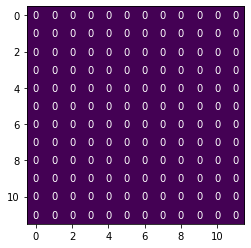

0
Agent is running!


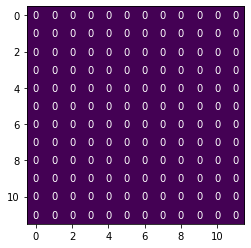

20


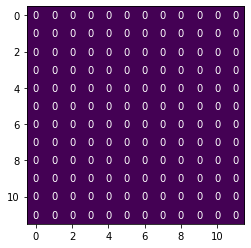

40


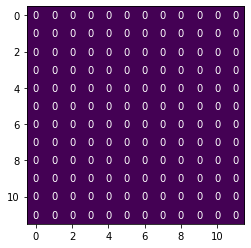

60


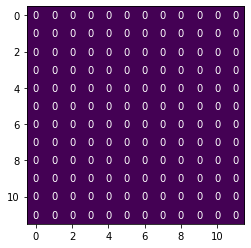

80


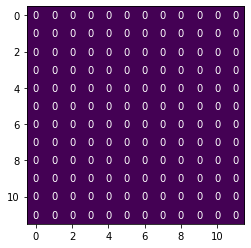

100


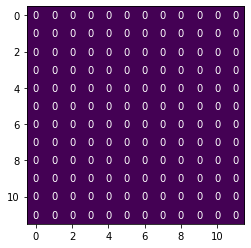

120


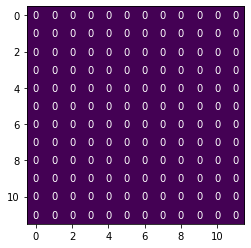

140


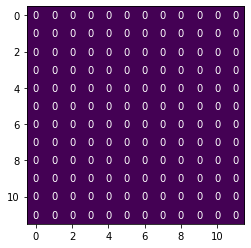

160


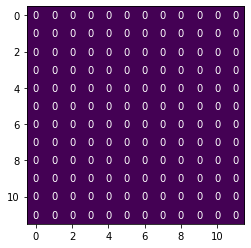

180


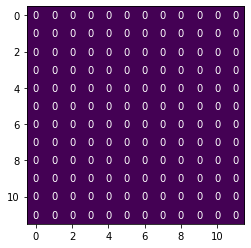

200


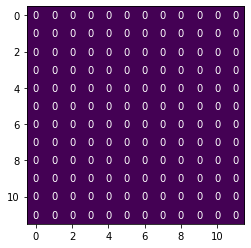

220


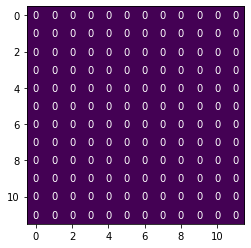

240


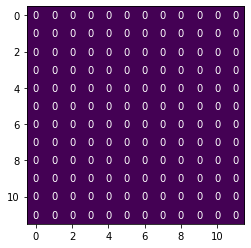

260


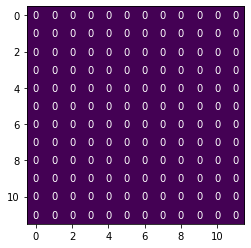

280


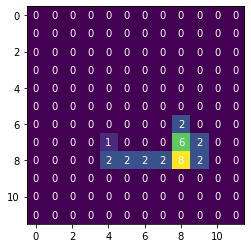

300


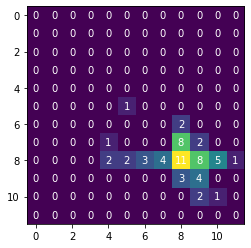

320


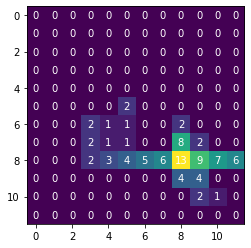

340


In [29]:
seed = random.choice(range(1,562124222))
#seed = 280287381
env = make("lux_ai_2021", configuration={"seed": seed, "loglevel": 0, "annotations": False}, debug=True)
env.run([agent, "simple_agent"])
env.render(mode = "ipython", width=800, height=600)

#### Run the game  --- #original seed 562124210

In [13]:
# for i in range(10):
#     successful_games = 0
#     seed = random.choice(range(1,562124222))
#     env = make("lux_ai_2021", configuration={"seed": seed, "loglevel": 0, "annotations": False}, debug=True)
#     steps = env.run([agent, "simple_agent"])
#     rewards = []
#     for step in steps:
#         rewards.append(step[0].reward)
#     if len(steps) == 361:
#         successful_games +=1
#         print(f"In game map = {seed}")
#         print(f"Agent survived till step = {len(steps)}")
#         print(f"average reward reached = {np.mean(rewards)}")
#         print(f"max reward reached = {np.max(rewards)}")
#         if np.max(rewards) > 20000:
#             env.render(mode="ipython", width=720, height=480)
# print(f"Success rate = {successful_games* 100/10}")